Training data size: torch.Size([19218, 1, 28, 28])
Validation data size: torch.Size([4118, 1, 28, 28])
Test data size: torch.Size([4119, 1, 28, 28])


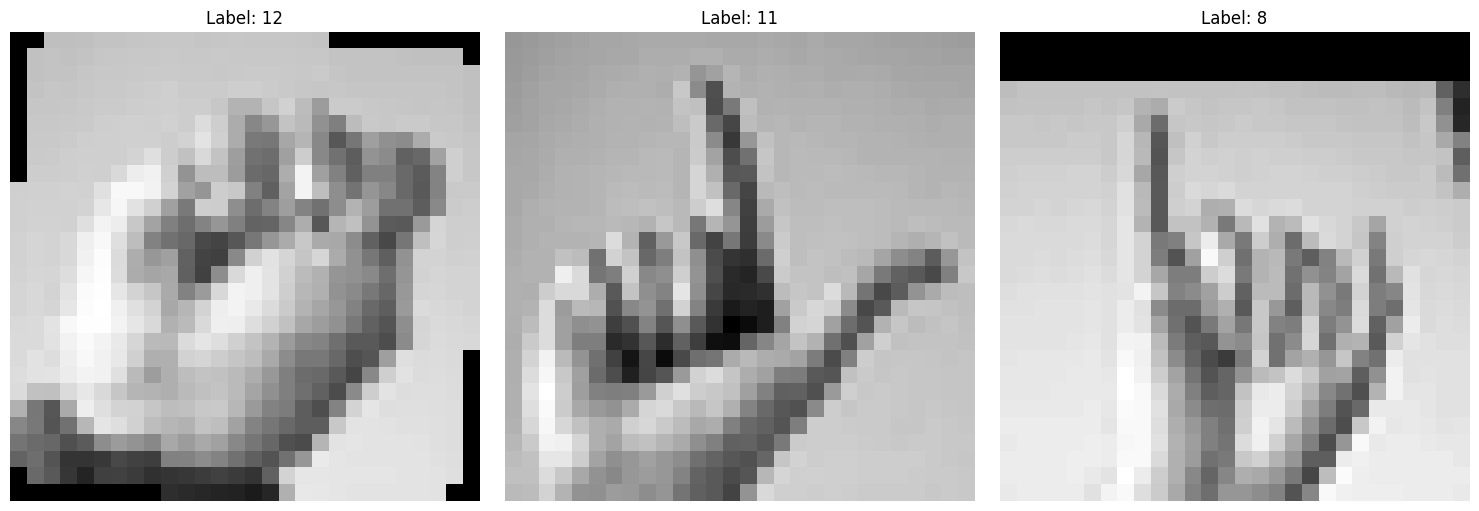

In [ ]:
# import necessary modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# loading dataset
train_df = pd.read_csv("data/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test.csv")

# splitting data (70% training, 15% validation, 15% testing)
X = train_df.drop("label", axis=1).values
y = train_df["label"].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# normalizing pixel values (0-255) to (0-1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# class to perform transformations
class ASLDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28)  # Reshape back to 2D
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# define transformations for training data
augmentations = transforms.Compose([
    transforms.ToPILImage(), # convert to PIL
    transforms.RandomApply([transforms.RandomResizedCrop(size=28, scale=(0.8, 1.2))], p=0.5),  # zoom
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.5),  # rotate
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),  # translate
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3)], p=0.5),  # brightness and contrast
    transforms.ToTensor(),  # convert back to tensor
])

# convert validation and test data to tensors without augmentation
transform_no_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# create datasets
train_dataset = ASLDataset(X_train, y_train, transform=augmentations)
val_dataset = ASLDataset(X_val, y_val, transform=transform_no_aug)
test_dataset = ASLDataset(X_test, y_test, transform=transform_no_aug)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# convert dataloaders to tensors for model input
def dataloader_to_tensor(loader):
    images, labels = [], []
    for batch_images, batch_labels in loader:
        images.append(batch_images)
        labels.append(batch_labels)
    return torch.cat(images).to(device), torch.cat(labels).to(device)

X_train_tensor, y_train_tensor = dataloader_to_tensor(train_loader)
X_val_tensor, y_val_tensor = dataloader_to_tensor(val_loader)
X_test_tensor, y_test_tensor = dataloader_to_tensor(test_loader)

# print sizes
print(f"Training data size: {X_train_tensor.shape}")
print(f"Validation data size: {X_val_tensor.shape}")
print(f"Test data size: {X_test_tensor.shape}")

# display random images with augmentations
def show_random_augmented_images(dataset, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))  # randomly pick an index
        image, label = dataset[idx]  # get image and label
        image = image.permute(1, 2, 0).cpu().numpy()  # convert tensor to numpy array for plotting
        axes[i].imshow(image, cmap='gray')  # display the image
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# display 3 random augmented images from the training dataset
show_random_augmented_images(train_dataset, num_images=3)


In [19]:
# Models

# first iteration
class Simple_NN(nn.Module):
    def __init__(self, num_classes, input_size=784):
        super(Simple_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x

# second iteration
class ASL_CNN(nn.Module):
    def __init__(self, num_classes):
        super(ASL_CNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        # dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# third iteration
class OptimizedASL_CNN(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedASL_CNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # less filters
        self.bn1 = nn.BatchNorm2d(16)  # using batch normalization
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        # dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1) # flattenning
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # output layer
        return x        

In [ ]:
#--------------Functions---------------------------
# defining training model
def train_model(model, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    return train_losses, val_losses

# confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

# evaluate model
def evaluate_model(model, class_names=None):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predictions = torch.max(outputs, 1)
        accuracy = (predictions == y_test_tensor).float().mean().item()
    # print test accuracy
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    # convert tensors to numpy arrays
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    # plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names=class_names)
    
    return predictions

# plotting losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# visualizing predictions
def plot_predictions(model, num_images=5):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor[:num_images])
        _, predictions = torch.max(outputs, 1)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = X_test_tensor[i].cpu().squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Predicted: {predictions[i].item()}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

Epoch [20/250], Train Loss: 3.1155, Val Loss: 3.0500
Epoch [40/250], Train Loss: 2.8479, Val Loss: 2.6458
Epoch [60/250], Train Loss: 2.6207, Val Loss: 2.3022
Epoch [80/250], Train Loss: 2.4760, Val Loss: 2.0806
Epoch [100/250], Train Loss: 2.3556, Val Loss: 1.9023
Epoch [120/250], Train Loss: 2.2693, Val Loss: 1.7608
Epoch [140/250], Train Loss: 2.1932, Val Loss: 1.6441
Epoch [160/250], Train Loss: 2.1389, Val Loss: 1.5584
Epoch [180/250], Train Loss: 2.0880, Val Loss: 1.4758
Epoch [200/250], Train Loss: 2.0322, Val Loss: 1.4139
Epoch [220/250], Train Loss: 2.0039, Val Loss: 1.3632
Epoch [240/250], Train Loss: 1.9763, Val Loss: 1.3154
Test Accuracy: 62.25%


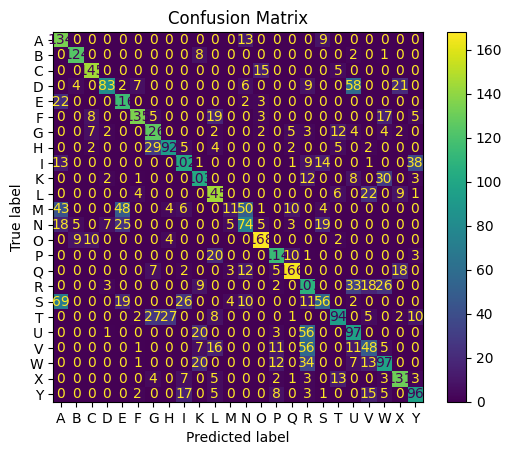

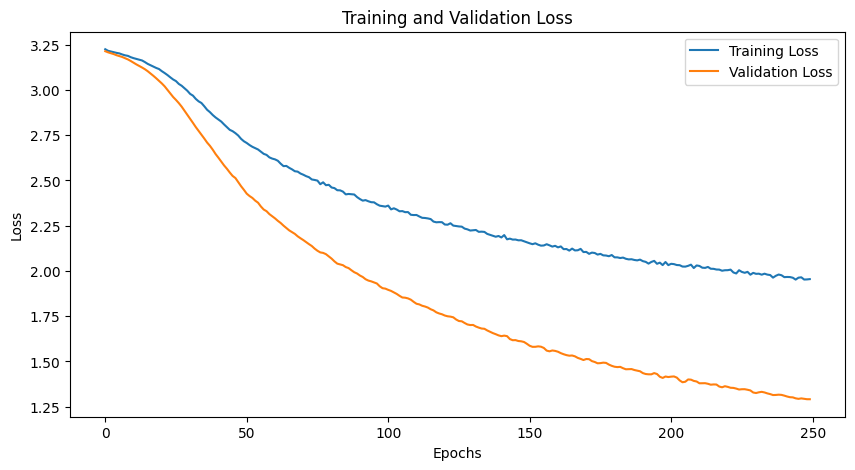

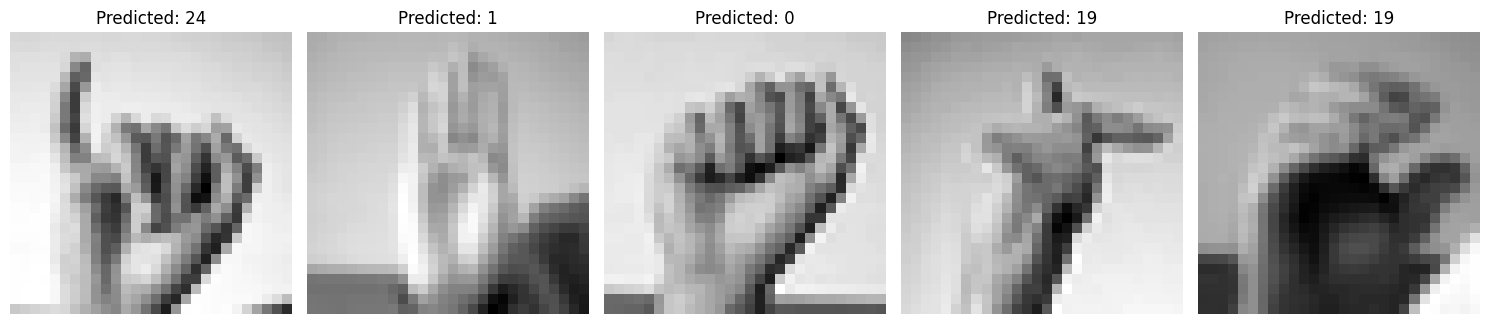

In [ ]:
#----------------Running first iteration model---------------------
# initializing
num_classes = max(y) + 1
class_names = [chr(i) for i in range(65, 91) if chr(i) not in {'J', 'Z'}]
model = Simple_NN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# training CNN
train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs=250)
# evaluating and printing results
predictions = evaluate_model(model, class_names=class_names)
plot_losses(train_losses, val_losses)
plot_predictions(model, num_images=5)
# save model to file
# torch.save(model.state_dict(), "asl_cnn_model.pth")
# print("Model Saved!")

Epoch [20/250], Train Loss: 3.0209, Val Loss: 2.9175
Epoch [40/250], Train Loss: 2.2441, Val Loss: 1.8975
Epoch [60/250], Train Loss: 1.6925, Val Loss: 1.2128
Epoch [80/250], Train Loss: 1.3429, Val Loss: 0.8674
Epoch [100/250], Train Loss: 1.1062, Val Loss: 0.6284
Epoch [120/250], Train Loss: 0.9829, Val Loss: 0.4806
Epoch [140/250], Train Loss: 0.8046, Val Loss: 0.3871
Epoch [160/250], Train Loss: 0.7031, Val Loss: 0.3043
Epoch [180/250], Train Loss: 0.6244, Val Loss: 0.2535
Epoch [200/250], Train Loss: 0.5453, Val Loss: 0.2015
Epoch [220/250], Train Loss: 0.4935, Val Loss: 0.1551
Epoch [240/250], Train Loss: 0.4568, Val Loss: 0.1255
Test Accuracy: 97.65%


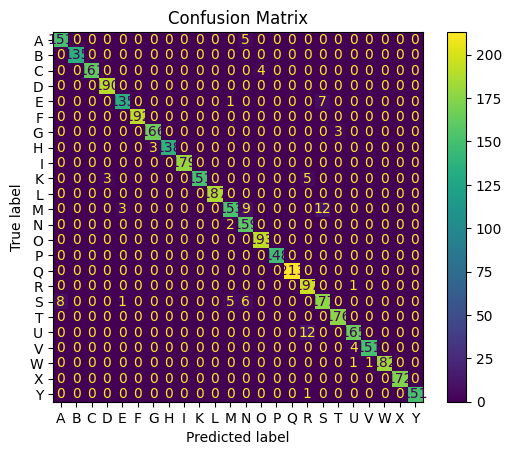

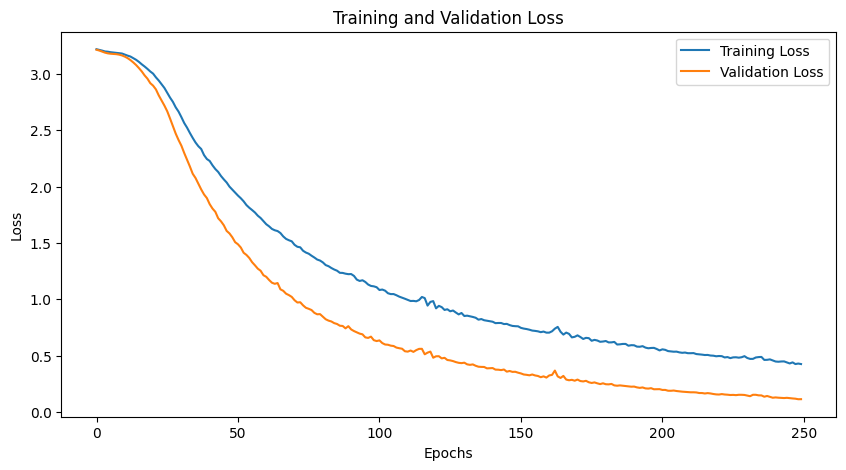

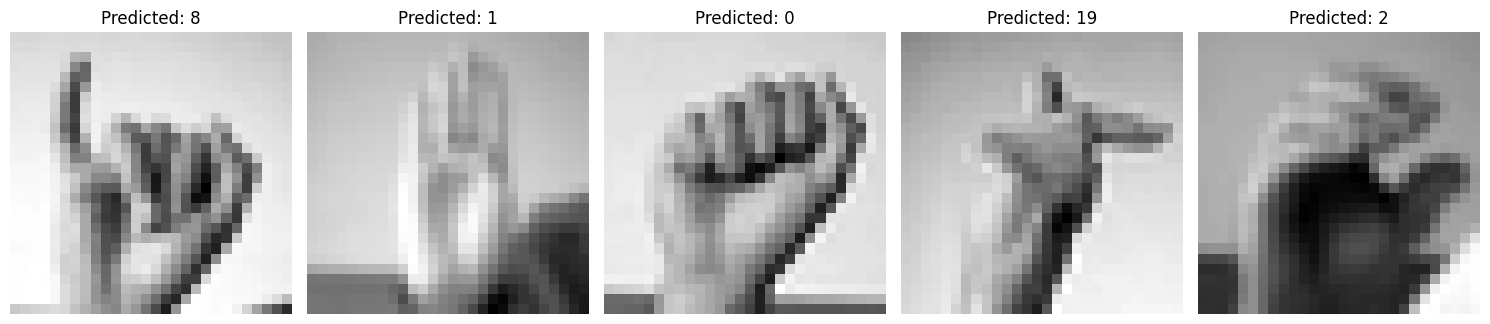

In [24]:
#----------------Running second iteration model---------------------
# initializing
num_classes = max(y) + 1
class_names = [chr(i) for i in range(65, 91) if chr(i) not in {'J', 'Z'}]
model = ASL_CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# training CNN
train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs=250)
# evaluating and printing results
predictions = evaluate_model(model, class_names=class_names)
plot_losses(train_losses, val_losses)
plot_predictions(model, num_images=5)
# save model to file
# torch.save(model.state_dict(), "asl_cnn_model.pth")
# print("Model Saved!")

Epoch [20/250], Train Loss: 2.3324, Val Loss: 2.8070
Epoch [40/250], Train Loss: 1.5566, Val Loss: 1.3498
Epoch [60/250], Train Loss: 1.1038, Val Loss: 0.5464
Epoch [80/250], Train Loss: 0.8478, Val Loss: 0.3047
Epoch [100/250], Train Loss: 0.6897, Val Loss: 0.1882
Epoch [120/250], Train Loss: 0.5764, Val Loss: 0.1230
Epoch [140/250], Train Loss: 0.4942, Val Loss: 0.0795
Epoch [160/250], Train Loss: 0.4334, Val Loss: 0.0591
Epoch [180/250], Train Loss: 0.3858, Val Loss: 0.0398
Epoch [200/250], Train Loss: 0.3360, Val Loss: 0.0284
Epoch [220/250], Train Loss: 0.3031, Val Loss: 0.0223
Epoch [240/250], Train Loss: 0.2755, Val Loss: 0.0150
Test Accuracy: 100.00%


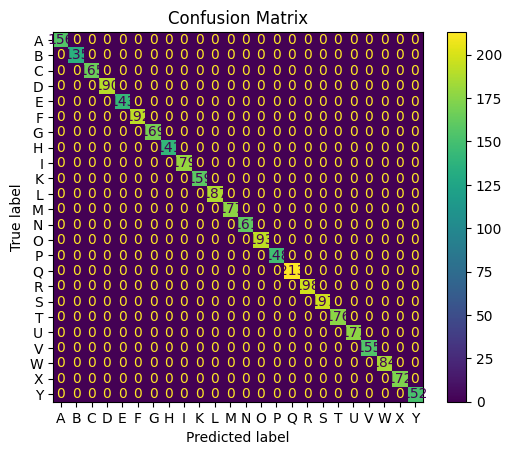

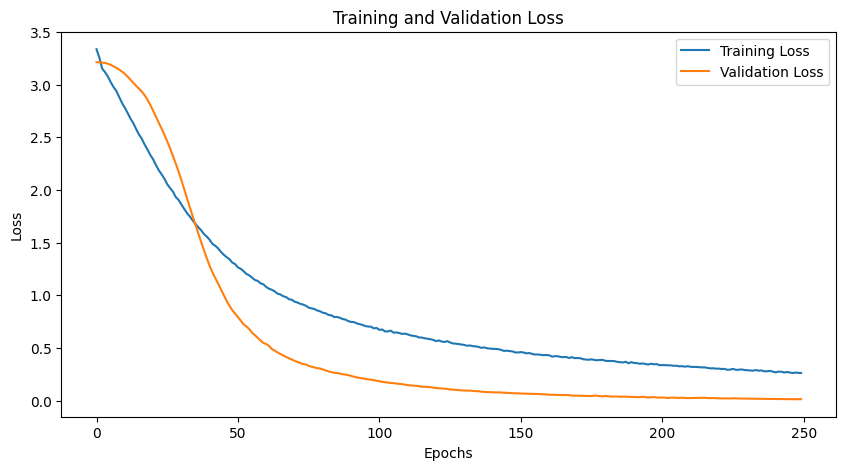

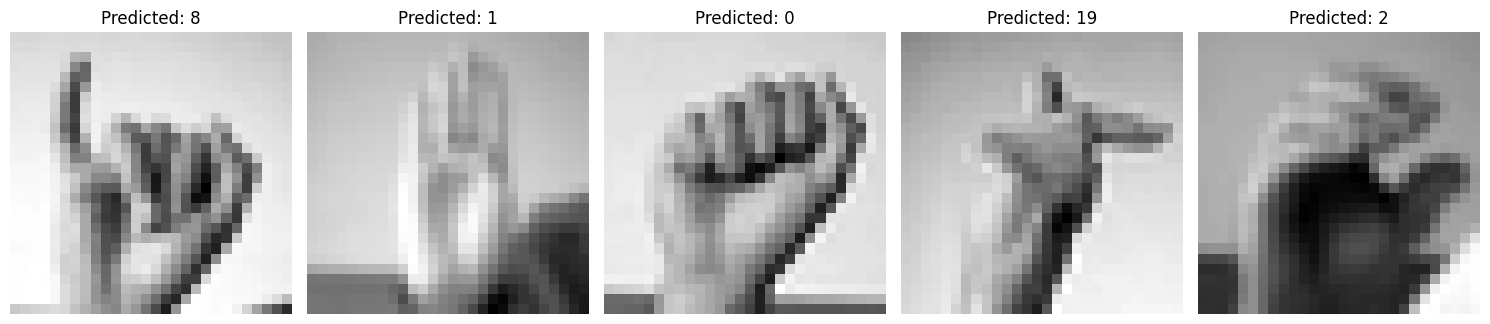

In [25]:
#----------------Running third iteration model---------------------
# initializing
num_classes = max(y) + 1
class_names = [chr(i) for i in range(65, 91) if chr(i) not in {'J', 'Z'}]
model = OptimizedASL_CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# training CNN
train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs=250)
# evaluating and printing results
predictions = evaluate_model(model, class_names=class_names)
plot_losses(train_losses, val_losses)
plot_predictions(model, num_images=5)
# save model to file
# torch.save(model.state_dict(), "asl_cnn_model.pth")
# print("Model Saved!")

C:\Users\iporwal\AppData\Local\Temp\ipykernel_13044\1926045464.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("asl_cnn_model.pth"))


Model loaded successfully!
Test Accuracy: 100.00%


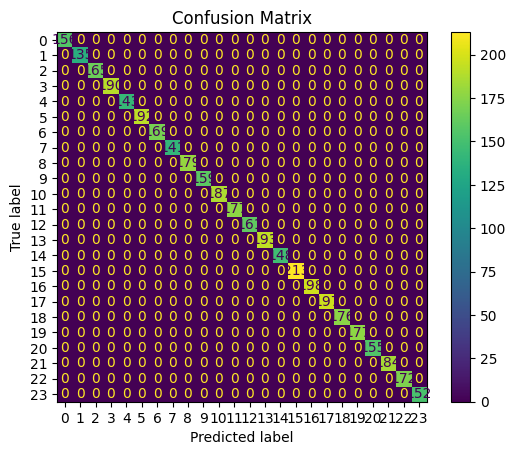

In [ ]:
# reload trained data
state_dict = torch.load("asl_cnn_model.pth", map_location=device)  # Load only the state dictionary
model.load_state_dict(state_dict)  # Load weights into the model
print("Model loaded successfully!")
# evaluate
predictions = evaluate_model(model)

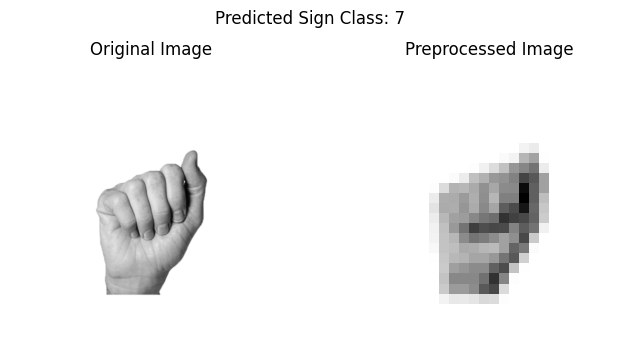

In [23]:
import requests
from PIL import Image
import torchvision.transforms as transforms
from io import BytesIO
import matplotlib.pyplot as plt
import torch

def predict(model, image_url, device = "cpu"):
    model.eval()
    # download image from url
    response = requests.get(image_url)
    if response.status_code != 200:
        print("donwload failed")
        return
    # process image making it greyscale
    img = Image.open(BytesIO(response.content)).convert("L")
    # transform to almost match training data
    transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    # predict
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_class = torch.max(outputs, 1)
    
    # display original and processed images
    plt.figure(figsize=(8, 4))
    # original image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    # processed image
    plt.subplot(1, 2, 2)
    img_preprocessed = img_tensor.squeeze(0).cpu().numpy()[0]
    plt.imshow(img_preprocessed, cmap="gray")
    plt.title("Preprocessed Image")
    plt.axis("off")
    plt.suptitle(f"Predicted Sign Class: {predicted_class.item()}")
    plt.show()
    return predicted_class.item()

# trying it out
image_url = "https://www.signingsavvy.com/images/words/alphabet/2/a1.jpg"
predicted_class = predict(model, image_url, device="cpu")